In [1]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs:  1


In [3]:
# Encontra diretorio atual
atual_dir = os.getcwd()

# Acessa arquivo pkl das noticias
parent_dir = os.path.split(atual_dir)

parent_dir = os.path.split(parent_dir[0])

parent_dir = os.path.split(parent_dir[0])

caminho_pkl = os.path.join(parent_dir[0], "Pre-processamento\\df_pre_processado.pkl")

# Carrega dataframe salvo em formato pickle
df = pd.read_pickle(caminho_pkl)

df.head()

,Texto,Categoria,label
0,"[poder, decidir, expulsar, deputado, federal, ...",Real,1
1,"[bolsonaro, liberal, completo, presidente, psl...",Real,1
2,"[ministro, stf, liberar, Andrea, Neves, prisao...",Real,1
3,"[apesar, abundancia, crescer, preocupacao, pre...",Real,1
4,"[harvard, mit, levarao, dilma, moro, suplicy, ...",Real,1


In [4]:
# Converte a coluna 'Texto' do DataFrame em uma lista e armazena na variável texts. O mesmo com as labels
texts = df['Texto'].tolist()
labels = df['label'].tolist()  

In [5]:
# Tokenização
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# word_index é um dicionário onde as chaves são as palavras e os valores são os índices dessas palavras.
# Esse índice é útil para várias tarefas de NLP, como a criação de embeddings de palavras ou a preparação de dados para modelos de deep learning.
word_index = tokenizer.word_index

In [6]:
# Salva o tokenizador em um arquivo (precisamos dele mais tarde, quando realizarmos as inferências)
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [7]:
# Carrega o valor de max_length de um arquivo pickle
caminho_max_length = os.path.join(parent_dir[0],"Pre-processamento\\max_length.pkl")
with open(caminho_max_length, 'rb') as f:
    max_length = pickle.load(f)

print("max_length: ", max_length)

max_length:  3835


In [8]:
# Carrega os embeddings do GLoVe
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [9]:
# Prepara a matriz de embedding
embedding_dim = 100  # o tamanho do GLoVe embeddings (100)
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [10]:
# One-hot encoding dos labels
num_classes = len(np.unique(labels))  # Número de classes únicas
labels = to_categorical(labels, num_classes=num_classes)

In [11]:
# Realiza o preenchimento das sequências com base no novo 'max_length'
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [12]:
# Divide os dados em um conjunto de treino (70%) e um conjunto temporário (30%)
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

# Divide o conjunto temporário em conjuntos de validação (15%) e teste (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [13]:
# Constrói o modelo
model = Sequential()  # Inicialização de um modelo sequencial
model.add(Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))  # Adicionando camada de incorporação com pesos pré-treinados e não treináveis
model.add(Bidirectional(LSTM(64, return_sequences=True, implementation=2)))  # Adicionando camada LSTM bidirecional com retorno de sequências
model.add(Bidirectional(LSTM(32, implementation=2)))  # Adicionando outra camada LSTM bidirecional
model.add(Dense(num_classes, activation='softmax'))  # Adicionando camada densa de saída para classificação multiclasse com ativação softmax

# Chamada ao Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # Configuração do Early Stopping para monitoramento da perda de validação e paciência 5

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compilação do modelo com função de perda, otimizador e métricas

# Treinamento do modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_val, y_val), callbacks=[early_stopping])  # Treinamento do modelo com os dados de treinamento, validação e chamada ao Early Stopping


Epoch 1/40
488/488 [==============================] - 596s 1s/step - loss: 0.5316 - accuracy: 0.7211 - val_loss: 0.5943 - val_accuracy: 0.7110
Epoch 2/40
488/488 [==============================] - 596s 1s/step - loss: 0.5344 - accuracy: 0.7123 - val_loss: 0.5355 - val_accuracy: 0.7131
Epoch 3/40
488/488 [==============================] - 578s 1s/step - loss: 0.4839 - accuracy: 0.7557 - val_loss: 0.4880 - val_accuracy: 0.7481
Epoch 4/40
488/488 [==============================] - 586s 1s/step - loss: 0.4503 - accuracy: 0.7780 - val_loss: 0.4765 - val_accuracy: 0.7643
Epoch 5/40
488/488 [==============================] - 593s 1s/step - loss: 0.4040 - accuracy: 0.8175 - val_loss: 0.3237 - val_accuracy: 0.8588
Epoch 6/40
488/488 [==============================] - 583s 1s/step - loss: 0.3030 - accuracy: 0.8742 - val_loss: 0.2780 - val_accuracy: 0.8860
Epoch 7/40
488/488 [==============================] - 592s 1s/step - loss: 0.2687 - accuracy: 0.8870 - val_loss: 0.3113 - val_accuracy: 0.8663

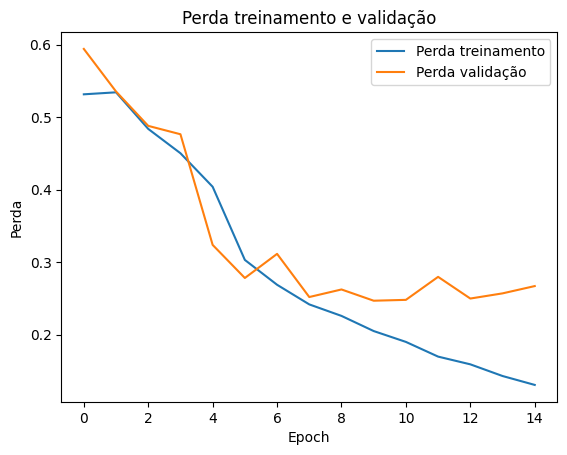

In [14]:
# Plota a perda (loss) e a perda de validação (val_loss) durante o treinamento
plt.plot(history.history['loss'], label='Perda treinamento')
plt.plot(history.history['val_loss'], label='Perda validação')
plt.title('Perda treinamento e validação')
plt.xlabel('Epoch')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [15]:
# Salva os arquivos
model.save('modelo_BiLSTM_glove6b100d.h5')
np.save("X_test_BiLSTM_glove6b100d.npy", X_test)
np.save("y_test_BiLSTM_glove6b100d.npy", y_test)